## **Load Libraries**

In [ ]:
from torchvision import models
import torch
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

import urllib

import numpy as np
import time
import glob
import os

In [ ]:
%matplotlib inline

## **U-Net Model for Robotic Grasping**

In [ ]:
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                      in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


## **Extract the input images from dataset**

In [ ]:
def get_images_and_mask_images(root='mri-images'):
    mask_images = glob.glob(os.path.join(root, '*_mask.tif'))
    
    images = []
    
    for m_img in mask_images:
        ind = m_img.find('_mask.tif')
        image_path = m_img[:ind] + '.tif'
        images.append((image_path, m_img))
    return images

In [ ]:
images = get_images_and_mask_images()

for img_tuple in images:
    print('{}\t{}'.format(img_tuple[0], img_tuple[1]))

## **Sample Medical Image dateset for segmentation**

In [ ]:
!wget https://www.dropbox.com/s/lgcmkj5zb97p1d9/mri-images.zip?dl=1 -O mri-images.zip
!unzip mri-images.zip -d ./
!rm mri-images.zip

--2022-03-30 08:58:00--  https://www.dropbox.com/s/lgcmkj5zb97p1d9/mri-images.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/lgcmkj5zb97p1d9/mri-images.zip [following]
--2022-03-30 08:58:01--  https://www.dropbox.com/s/dl/lgcmkj5zb97p1d9/mri-images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f12a90174ddeaf78538564aeb.dl.dropboxusercontent.com/cd/0/get/Bia6tOtsv6y-M5EBkVgLp7ACSoHkvgMXTIVND40yUpXycBEnbxQ77Qvddc17R7ZsgxkhXSQ3U7TUaNJ6VJ8jWYqORVW9GPNgzUmlxpgao8g8aH2YVaaRrerciqeOW_A27lxqI70756tQggMr5h9em7QlSThfUA_FpgOi-2tGB2N_nJz5y8DEjEFTyAJRLgVY808/file?dl=1# [following]
--2022-03-30 08:58:01--  https://uc8f12a90174ddeaf78538564aeb.dl.dropboxusercontent.com/cd/0/get/Bia6tOtsv6y-M5EBkVgLp7ACSoHkvgMXTIVND40

In [ ]:
images = get_images_and_mask_images()

for img_tuple in images:
    print('{}\t{}'.format(img_tuple[0], img_tuple[1]))

mri-images/TCGA_DU_7014_19860618_26.tif	mri-images/TCGA_DU_7014_19860618_26_mask.tif
mri-images/TCGA_CS_4944_20010208_7.tif	mri-images/TCGA_CS_4944_20010208_7_mask.tif
mri-images/TCGA_CS_4944_20010208_12.tif	mri-images/TCGA_CS_4944_20010208_12_mask.tif
mri-images/TCGA_DU_5855_19951217_14.tif	mri-images/TCGA_DU_5855_19951217_14_mask.tif
mri-images/TCGA_DU_5855_19951217_16.tif	mri-images/TCGA_DU_5855_19951217_16_mask.tif


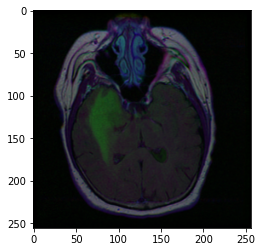

Mask image (ground truth)


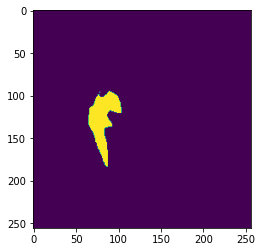

In [ ]:
img = Image.open(images[0][0]).convert("RGB")
plt.imshow(img) 
plt.show()

print('Mask image (ground truth)')
mask_img = Image.open(images[0][1])
plt.imshow(mask_img) 
plt.show()


In [ ]:
# the cuda device name
cuda_device = 'cuda:0'

In [ ]:
# pre-procees the input image
preprocess = T.Compose([ T.ToTensor(),])

# preprocess
input_tensor = preprocess(img)

# prepare as batch
input_batch = input_tensor.unsqueeze(0)

# check if cuda is available if true use the specified cuda/GPU
if torch.cuda.is_available():
    input_batch = input_batch.to(cuda_device)
    unet = unet.to(cuda_device)

# Infer the model
with torch.no_grad():
    output = unet(input_batch)

# rounding the out will give 1 if value > 0.5.
# One can use threshold other than 0.5
pred = torch.round(output[0]).squeeze().detach().cpu().numpy()

Prediction


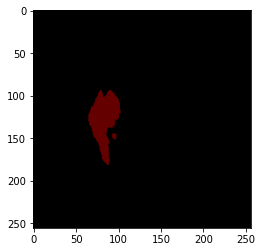

In [ ]:
# Conver prediction as 3-channel image
r = np.zeros_like(pred).astype(np.uint8)
g = np.zeros_like(pred).astype(np.uint8)
b = np.zeros_like(pred).astype(np.uint8)

# Get all index that have value 1
idx = pred == 1

# update index of r-channel with value 100
# one may update with other value. Even one can update other channels also.
r[idx] = 100

# stact to form an image
pred_img = np.stack([r, g, b], axis=2)

print('Prediction')
plt.imshow(pred_img)
plt.show()

In [ ]:
def Robotic_Grasp_Segementation(model, img_path, mask_path, cuda_device=None):
    """
    This function will take model, input image path, mask image path, and cuda_device
    and plot image, mask and prediction mask
    
    parameters:
    
    model (nn.module): model, e.g. U-Net
    img_path (str): Input image path
    mask_path (str): mask image path (ground truth)
    cuda_device (str): cuda device name, e.g. cuda, cuda:0, cuda:2
    
    
    """
    
    plt.rcParams["figure.figsize"] = (15, 5)
    plt.figure
    img = resized_down
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.gca().set_title('Input Image')
    plt.axis('off')
    
    mask_img = resized_down
    plt.subplot(1, 3, 2)
    plt.imshow(mask_img)
    plt.gca().set_title('Mask (G-truth)')
    plt.axis('off')
    
    input_tensor = preprocess(img)

    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to(cuda_device)
        model = model.to(cuda_device)

    with torch.no_grad():
        output = model(input_batch)

    # rounding the out will give 1 if value > 0.5
    pred = torch.round(output[0]).squeeze().detach().cpu().numpy()
    
    r = np.zeros_like(pred).astype(np.uint8)
    g = np.zeros_like(pred).astype(np.uint8)
    b = np.zeros_like(pred).astype(np.uint8)

    idx = pred == 1
    r[idx] = 100
    pred_img = np.stack([r, g, b], axis=2)
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_img)
    plt.gca().set_title('Pred Segments')
    plt.axis('off')
    plt.show()
    
    return
    

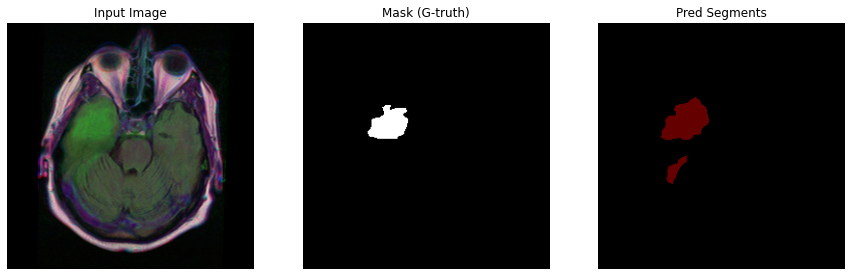

In [ ]:
brain_mri_abnormally_detection(unet, images[1][0], images[1][1], cuda_device)

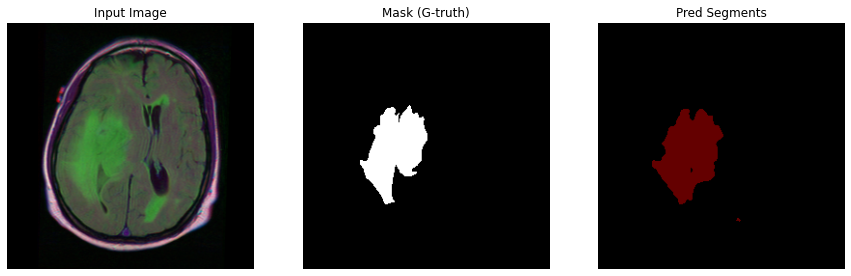

In [ ]:
brain_mri_abnormally_detection(unet, images[2][0], images[2][1], cuda_device)

In [ ]:
#img = Image.open("/content/Grasp.jpg").convert('RGB')
img = ("/content/Grasp.jpg")

In [ ]:
import cv2
img_cv = cv2.imread("/content/Grasp.jpg")
img_cv.shape

(935, 1240, 3)

In [ ]:
down_width = 300
down_height = 200
down_points = (down_width, down_height)
resized_down = cv2.resize(img_cv, down_points, interpolation= cv2.INTER_LINEAR)


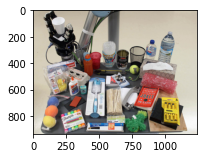

In [ ]:
Mask_Image = Image.open("/content/Predicted output.png")
plt.subplot(2,1,1);plt.imshow(img);plt.show()


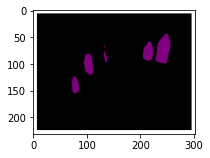

In [ ]:
Robotic_Grasp_Segementation(unet, resized_down, img, cuda_device)

In [ ]:
cd test

[Errno 2] No such file or directory: 'test'
/content
